# Modelling - Secondary Freight Cost

The aim of this notebook is to illustrate how we can model secondary freight transport for an organisation.
This notebook is focussed on the following
- Acquire the data for the secondary network - freight data and location-distance matrix
- Refine, clean up and merge the datasets to create singular dataset
- Transform to create new variables for modelling
- Explore to generate hypothesis for modelling
- Model the secondary freight cost - Linear Model, Tree Based Model

## Acquire the Data

In [1]:
import numpy as np 
import pandas as pd

In [2]:
freight = pd.read_csv('10-Secondary-Freight-Data.csv')

In [3]:
freight.head()

Sales Order No. New      Date Supplying DC Location  Customer Code New  \
0           2004912014  1-Jul-08                  Pune             190886   
1           2004912846  1-Jul-08            Ahemadabad             190406   
2           2004913418  1-Jul-08                Jaipur             188582   
3           2004916450  2-Jul-08                Raipur             191024   
4           2004916806  2-Jul-08             Zirakhpur             207786   

  Customer Town  Qty (in cases) Freight/Cartage                    Remarks  \
0          PUNE            15.0               5         Charges - Per case   
1      JAMNAGAR            30.0              18         Charges - Per case   
2         BAGRU             6.0              20         Charges - Per case   
3        RAIPUR            23.0               5         Charges - Per case   
4         Banur             1.0           1,000  Charges - Per Consignment   

  Amount  
0     75  
1    540  
2    120  
3    104  
4  1,000

In [4]:
matrix = pd.read_csv('13-location-distance-matrix.csv')

In [5]:
matrix.head()

Source  S. Longitude  S. Latitude Destination  D. Longitude  \
0  BANGALORE         77.59        12.98   BANGALORE         77.59   
1  BANGALORE         77.59        12.98     CHENNAI         80.24   
2  BANGALORE         77.59        12.98      MUMBAI         72.84   
3  BANGALORE         77.59        12.98   HYDERABAD         78.49   
4  BANGALORE         77.59        12.98   NEW DELHI         77.17   

   D. Latitude                    Lane  Distance  
0        12.98  BANGALORE to BANGALORE      0.00  
1        13.07    BANGALORE to CHENNAI    294.47  
2        18.98     BANGALORE to MUMBAI    554.79  
3        17.39  BANGALORE to HYDERABAD    142.09  
4        28.62  BANGALORE to NEW DELHI    381.46

In [6]:
freight.dtypes

Sales Order No. New        int64
Date                      object
Supplying DC Location     object
Customer Code New          int64
Customer Town             object
Qty (in cases)           float64
Freight/Cartage           object
Remarks                   object
Amount                    object
dtype: object

## Refine the Data

- **Basic Cleaning** 
    - Add column names (short) to the dataframe
    - Drop redundant columns `orderno` and `code` and `lane`
    - Remove commas from numeric columns
- **Fix Datatypes**
- **Drop Missing Values**
- **Standardize Text Field**
   - Shorten the units to "case" and "consignment"
   - Fix names in `source` and `dest` columns
   - Align city names in `data` and `city` frames


### Basic Cleaning

In [7]:
freight_columns = {
    'Sales Order No. New': 'orderno', 
    'Date': 'date', 
    'Supplying DC Location': 'source',
    'Customer Code New': 'custcode',
    'Customer Town': 'dest',
    'Qty (in cases)': 'qty',
    'Freight/Cartage': 'cartage',
    'Remarks': 'unit',
    'Amount': 'amount'
}

In [8]:
freight.columns = freight.columns.to_series().replace(freight_columns)

In [9]:
matrix_columns = {
    'Source': 'source',
    'S. Longitude': 'sourcelon',
    'S. Latitude': 'sourcelat',
    'Destination': 'dest',
    'D. Longitude': "destlon",
    'D. Latitude': "destlat",
    'Lane': 'lane',
    'Distance': 'distance'
}

In [10]:
matrix.columns = matrix.columns.to_series().replace(matrix_columns)

In [11]:
freight.drop(['orderno', 'custcode'], axis=1, inplace=True)
matrix.drop(['lane'], axis=1, inplace=True)

In [12]:
freight.head()

date      source      dest   qty cartage                       unit  \
0  1-Jul-08        Pune      PUNE  15.0       5         Charges - Per case   
1  1-Jul-08  Ahemadabad  JAMNAGAR  30.0      18         Charges - Per case   
2  1-Jul-08      Jaipur     BAGRU   6.0      20         Charges - Per case   
3  2-Jul-08      Raipur    RAIPUR  23.0       5         Charges - Per case   
4  2-Jul-08   Zirakhpur     Banur   1.0   1,000  Charges - Per Consignment   

  amount  
0     75  
1    540  
2    120  
3    104  
4  1,000

In [13]:
matrix.head()

source  sourcelon  sourcelat       dest  destlon  destlat  distance
0  BANGALORE      77.59      12.98  BANGALORE    77.59    12.98      0.00
1  BANGALORE      77.59      12.98    CHENNAI    80.24    13.07    294.47
2  BANGALORE      77.59      12.98     MUMBAI    72.84    18.98    554.79
3  BANGALORE      77.59      12.98  HYDERABAD    78.49    17.39    142.09
4  BANGALORE      77.59      12.98  NEW DELHI    77.17    28.62    381.46

### Fix Data Types

In [14]:
freight.cartage.unique()

array(['5', '18', '20', '1,000', '21', '15', '23', '12', '13', '10', '19',
       '17', '16', '24', '45', '250', '550', '31', '7', '750', '30', '27',
       '42', '26', '36', '2', '22', '275', '37', '25', '43', '44', '1',
       '28', '29', '35', '46', '59', '49', '9', '41', '33', '57', '289',
       '39', '32', '38', '14', '1,200', '34', '3', '40', '60', '4', '84',
       '288', '62', '55', '125', '50', '66', '6', '769', '53', '52', '48',
       '11', '51', '47', '295', '83', '64', '70', '204', '65', '287',
       '350', '54', '8', '0'], dtype=object)

In [15]:
# Remove commas in `amount` and `cartage`
freight.amount = freight.amount.astype(str).str.replace(",", "")
freight.cartage = freight.cartage.astype(str).str.replace(",", "")

In [16]:
freight.amount.unique()

array(['75', '540', '120', ..., '18960', '2788', '5117'], dtype=object)

In [17]:
# Fix data types
freight.amount = pd.to_numeric(freight.amount)
freight.cartage = pd.to_numeric(freight.cartage)
freight.date = pd.to_datetime(freight.date)

matrix.distance = pd.to_numeric(matrix.distance)

In [18]:
# Check the data types
freight.dtypes

date       datetime64[ns]
source             object
dest               object
qty               float64
cartage             int64
unit               object
amount              int64
dtype: object

In [19]:
# Check the data types
matrix.dtypes

source        object
sourcelon    float64
sourcelat    float64
dest          object
destlon      float64
destlat      float64
distance     float64
dtype: object

### Remove Missing Values

In [20]:
# Remove NaN values from the dc names
freight.isnull().sum()

date       0
source     6
dest       0
qty        0
cartage    0
unit       0
amount     0
dtype: int64

In [21]:
# Check the NaN values 
freight[freight.source.isnull()]

date source dest    qty  cartage                unit  amount
28572 2008-12-29    NaN  LEH  120.0        0  Charges - Per case       0
34377 2009-01-31    NaN  LEH  109.0        0  Charges - Per case       0
45204 2009-03-31    NaN  LEH   15.0        0  Charges - Per case       0
52852 2009-05-18    NaN  LEH  135.0        0  Charges - Per case       0
53438 2009-05-22    NaN  LEH  160.0        0  Charges - Per case       0
60903 2009-06-30    NaN  LEH  154.0        0  Charges - Per case       0

In [22]:
# Remove NaN values
freight.dropna(inplace=True)

### Standardize Text Fields

In [23]:
# Shorten unit to "case" and "consignment"
shortunits = {"Charges - Per case" : "case", "Charges - Per Consignment": "consignment"}
freight["unit"] = freight.unit.replace(shortunits)

In [24]:
# Make source and dest in a standard way - Strip Trailing Whitespace, Capitalize
freight.source = freight.source.str.strip()
freight.source = freight.source.str.capitalize()

freight.dest = freight.dest.str.strip()
freight.dest = freight.dest.str.capitalize()

matrix.source = matrix.source.str.strip()
matrix.source = matrix.source.str.capitalize()

matrix.dest = matrix.dest.str.strip()
matrix.dest = matrix.dest.str.capitalize()

In [25]:
freight.head()

date      source      dest   qty  cartage         unit  amount
0 2008-07-01        Pune      Pune  15.0        5         case      75
1 2008-07-01  Ahemadabad  Jamnagar  30.0       18         case     540
2 2008-07-01      Jaipur     Bagru   6.0       20         case     120
3 2008-07-02      Raipur    Raipur  23.0        5         case     104
4 2008-07-02   Zirakhpur     Banur   1.0     1000  consignment    1000

In [26]:
matrix.head()

source  sourcelon  sourcelat       dest  destlon  destlat  distance
0  Bangalore      77.59      12.98  Bangalore    77.59    12.98      0.00
1  Bangalore      77.59      12.98    Chennai    80.24    13.07    294.47
2  Bangalore      77.59      12.98     Mumbai    72.84    18.98    554.79
3  Bangalore      77.59      12.98  Hyderabad    78.49    17.39    142.09
4  Bangalore      77.59      12.98  New delhi    77.17    28.62    381.46

In [27]:
freight.source.nunique(), matrix.source.nunique()

(31, 54)

In [28]:
# Clean up the dc names
freight.source.sort_values().unique()

array(['Ahemadabad', 'Bangalore', 'Bbsr', 'Bhiwandi', 'Chandigarh',
       'Chennai', 'Cochin', 'Coimbatore', 'Delhi', 'Gauwhati', 'Ghaziabad',
       'Goa', 'Haldwani', 'Hyderabad', 'Indore', 'Jaipur', 'Jammu',
       'Kolkata', 'Lucknow', 'Madurai', 'Nagpur', 'Parwanoo', 'Patna',
       'Pune', 'Raipur', 'Ranchi', 'Rishikesh', 'Rohtak', 'Varanasi',
       'Vijaywada', 'Zirakhpur'], dtype=object)

In [29]:
freight.source.sort_values().unique()

array(['Ahemadabad', 'Bangalore', 'Bbsr', 'Bhiwandi', 'Chandigarh',
       'Chennai', 'Cochin', 'Coimbatore', 'Delhi', 'Gauwhati', 'Ghaziabad',
       'Goa', 'Haldwani', 'Hyderabad', 'Indore', 'Jaipur', 'Jammu',
       'Kolkata', 'Lucknow', 'Madurai', 'Nagpur', 'Parwanoo', 'Patna',
       'Pune', 'Raipur', 'Ranchi', 'Rishikesh', 'Rohtak', 'Varanasi',
       'Vijaywada', 'Zirakhpur'], dtype=object)

In [30]:
matrix.source.sort_values().unique()

array(['Ahmedabad', 'Bangalore', 'Bareilly', 'Barhampur', 'Bhiwandi',
       'Bhubaneshwar', 'Chandigarh', 'Chennai', 'Cochin', 'Coimbatore',
       'Delhi', 'Dimapur', 'Ghaziabad', 'Goa', 'Guwahati', 'Haldwani',
       'Hubli', 'Hyderabad', 'Imphal', 'Indore', 'Jaipur', 'Jammu',
       'Jamshedpur', 'Kanpur', 'Kolkata', 'Kollam', 'Lucknow', 'Ludhiana',
       'Madanapalle', 'Madurai', 'Mangalore', 'Mumbai', 'Mysore', 'Nagpur',
       'New delhi', 'Parwanoo', 'Patna', 'Pudukottai', 'Pune', 'Raipur',
       'Ranchi', 'Rishikesh', 'Rohtak', 'Salem', 'Secunderabad',
       'Srinagar', 'Thane', 'Tirunelveli', 'Tirupur', 'Trichy', 'Varanasi',
       'Vijaywada', 'Vishakapatnam', 'Zirakpur'], dtype=object)

In [31]:
# Correct spelling for the DC names
names_freight_source = {'Ahemadabad': 'Ahmedabad', 'Bbsr' : 'Bhubaneshwar', 'Gauwhati': 'Guwahati'}
freight.source = freight.source.replace(names_freight_source)

names_matrix_source = {"New delhi" : "Delhi", "Zirakpur": "Zirakhpur"}
matrix.source = matrix.source.replace(names_matrix_source)

In [32]:
# Check if all the origin and dc names match
freight.source.isin(matrix.source).value_counts()

True    60970
Name: source, dtype: int64

In [33]:
# Clean up the Town names
freight.dest.nunique(), matrix.dest.nunique()

(1818, 1824)

In [34]:
# Check how many town names are matching
freight.dest.isin(matrix.dest).value_counts()

True    60970
Name: dest, dtype: int64

In [35]:
freight.dest.sort_values().unique()

array(['Abohar', 'Abu road', 'Achampet', ..., 'Zaheerabad', 'Zira',
       'Zirakpur'], dtype=object)

In [36]:
matrix.dest.sort_values().unique()

array(['Abohar', 'Abu road', 'Achampet', ..., 'Zaheerabad', 'Zira',
       'Zirakpur'], dtype=object)

In [37]:
freight[freight.source.isin(matrix.source)].amount.sum()

40847966

# Transform the Data

**Merge two datsets**
- Drop repeated `dest` and `source` columns in matrix
- Remove "Consignment" from the data
- Add `distance` , `lat` and `long` for each Source  - Destination
- Drop rows where distance is not available

**Create New Variables**
- Make inter-city distance as 5 (from 0)
- Calculate `cartage_per_km`


### Merge Two Datasets

In [38]:
# Create the final dataset
secondary = freight.copy()
matrix_merge = matrix.copy()

In [39]:
# Total Spend Amount
secondary.amount.sum()

40847966

In [40]:
# Spend by "Case" and "Consignment"
secondary.groupby("unit").amount.sum()

unit
case           39015489
consignment     1832477
Name: amount, dtype: int64

In [41]:
# Remove "Consignment" from the data
secondary.drop(secondary[secondary.unit == "consignment"].index, inplace=True)

In [42]:
# Total Spend only for "Case"
secondary.amount.sum()

39015489

In [43]:
secondary.head()

date     source             dest   qty  cartage  unit  amount
0 2008-07-01       Pune             Pune  15.0        5  case      75
1 2008-07-01  Ahmedabad         Jamnagar  30.0       18  case     540
2 2008-07-01     Jaipur            Bagru   6.0       20  case     120
3 2008-07-02     Raipur           Raipur  23.0        5  case     104
5 2008-07-02     Raipur  Saripali (c.g.)   4.0       21  case      84

Merge the `matrix1` dataframes into `data`

In [44]:
# Combine origin | destination
matrix_merge['key'] = matrix_merge.source + " | " + matrix_merge.dest
secondary['key'] = secondary.source + " | " + secondary.dest

In [45]:
# Drop repeated `dest` and `source` columns
matrix_merge.drop(["source", "dest"], axis=1, inplace=True)

In [46]:
secondary.key.isin(matrix_merge.key).value_counts()

True     51181
False     6595
Name: key, dtype: int64

In [47]:
secondary = secondary.merge(matrix_merge, how="left", on="key")

In [48]:
secondary.head()

date     source             dest   qty  cartage  unit  amount  \
0 2008-07-01       Pune             Pune  15.0        5  case      75   
1 2008-07-01  Ahmedabad         Jamnagar  30.0       18  case     540   
2 2008-07-01     Jaipur            Bagru   6.0       20  case     120   
3 2008-07-02     Raipur           Raipur  23.0        5  case     104   
4 2008-07-02     Raipur  Saripali (c.g.)   4.0       21  case      84   

                        key  sourcelon  sourcelat  destlon  destlat  distance  
0               Pune | Pune      73.85      18.53    73.85    18.53      0.00  
1      Ahmedabad | Jamnagar      72.60      23.03    70.06    22.46    282.60  
2            Jaipur | Bagru      75.81      26.92    75.53    26.82     30.66  
3           Raipur | Raipur      81.65      21.23    81.65    21.23      0.00  
4  Raipur | Saripali (c.g.)      81.65      21.23    82.53    21.18     98.64

In [49]:
# Check how many key's are not there
secondary.shape[0], secondary.distance.isnull().sum()

(60340, 6595)

In [50]:
# Check how many key's are not there
distance_na = secondary.distance.isnull()
secondary[distance_na].amount.sum(), secondary[~distance_na].amount.sum()

(4965773, 35339545)

In [51]:
# Drop the missing distance
secondary.dropna(inplace = True)

In [52]:
# Drop redundant columns
secondary.drop(["key", "unit"], axis =1, inplace=True)

In [53]:
secondary.head()

date     source             dest   qty  cartage  amount  sourcelon  \
0 2008-07-01       Pune             Pune  15.0        5      75      73.85   
1 2008-07-01  Ahmedabad         Jamnagar  30.0       18     540      72.60   
2 2008-07-01     Jaipur            Bagru   6.0       20     120      75.81   
3 2008-07-02     Raipur           Raipur  23.0        5     104      81.65   
4 2008-07-02     Raipur  Saripali (c.g.)   4.0       21      84      81.65   

   sourcelat  destlon  destlat  distance  
0      18.53    73.85    18.53      0.00  
1      23.03    70.06    22.46    282.60  
2      26.92    75.53    26.82     30.66  
3      21.23    81.65    21.23      0.00  
4      21.23    82.53    21.18     98.64

### Create New Variables

In [54]:
# Make default inter city distance as 5
secondary.loc[secondary.distance == 0, "distance"] = 5

In [55]:
secondary["cartage_per_km"] = secondary["cartage"] / secondary["distance"]

In [56]:
secondary.head()

date     source             dest   qty  cartage  amount  sourcelon  \
0 2008-07-01       Pune             Pune  15.0        5      75      73.85   
1 2008-07-01  Ahmedabad         Jamnagar  30.0       18     540      72.60   
2 2008-07-01     Jaipur            Bagru   6.0       20     120      75.81   
3 2008-07-02     Raipur           Raipur  23.0        5     104      81.65   
4 2008-07-02     Raipur  Saripali (c.g.)   4.0       21      84      81.65   

   sourcelat  destlon  destlat  distance  cartage_per_km  
0      18.53    73.85    18.53      5.00        1.000000  
1      23.03    70.06    22.46    282.60        0.063694  
2      26.92    75.53    26.82     30.66        0.652316  
3      21.23    81.65    21.23      5.00        1.000000  
4      21.23    82.53    21.18     98.64        0.212895

In [57]:
# Save data for visualisation
secondary.to_csv("secondary.csv", index=False, date_format='%Y-%m-%d %H:%M:%S')

## Explore

- Check for **variation in cartage rates by time**
- **Aggregate data over routes** and remove time element
- **Explore Cartage & Distance**

In [58]:
secondary["key"] = secondary.source + " | " + secondary.dest

In [59]:
# Standard Deviation by Routes
route_std = secondary.groupby("key").cartage.std()
route_std.value_counts()

0.000000     1410
2.462961        1
2.386378        1
3.829708        1
4.712121        1
1.054093        1
0.773424        1
0.450225        1
18.961218       1
2.905092        1
0.551364        1
4.284857        1
1.388730        1
7.807881        1
6.966903        1
4.569226        1
2.745873        1
0.472742        1
1.190891        1
0.876162        1
1.426785        1
3.549648        1
Name: cartage, dtype: int64

In [60]:
# Percentage of routes with Standard Deviation greater than 0
route_std[route_std >0].count()/ route_std.count()* 100

1.4675052410901468

Most routes don't have variation in cartage rates. Lets aggregate the routes based on the following
- cartage: mean
- amount: sum
- qty: sum

In [61]:
secondary.head()

date     source             dest   qty  cartage  amount  sourcelon  \
0 2008-07-01       Pune             Pune  15.0        5      75      73.85   
1 2008-07-01  Ahmedabad         Jamnagar  30.0       18     540      72.60   
2 2008-07-01     Jaipur            Bagru   6.0       20     120      75.81   
3 2008-07-02     Raipur           Raipur  23.0        5     104      81.65   
4 2008-07-02     Raipur  Saripali (c.g.)   4.0       21      84      81.65   

   sourcelat  destlon  destlat  distance  cartage_per_km  \
0      18.53    73.85    18.53      5.00        1.000000   
1      23.03    70.06    22.46    282.60        0.063694   
2      26.92    75.53    26.82     30.66        0.652316   
3      21.23    81.65    21.23      5.00        1.000000   
4      21.23    82.53    21.18     98.64        0.212895   

                        key  
0               Pune | Pune  
1      Ahmedabad | Jamnagar  
2            Jaipur | Bagru  
3           Raipur | Raipur  
4  Raipur | Saripali (c.g.)

In [62]:
agg_func = {"cartage": ["mean"], "qty": ["sum"], "amount": ["sum"] }
data = secondary.groupby(["source", "dest", "sourcelat", "sourcelon", "destlat", "destlon", "distance"]).agg(agg_func).reset_index(col_level=0)
data.columns = data.columns.droplevel(1)

# Recalculate cartage_per_km
data["cartage_per_km"] = data["cartage"] / data["distance"]

data.head()

source       dest  sourcelat  sourcelon  destlat  destlon  distance  \
0  Ahmedabad  Ahmadabad      23.03       72.6    23.03    72.60      5.00   
1  Ahmedabad  Ahmedabad      23.03       72.6    23.03    72.60      5.00   
2  Ahmedabad   Ahmedabd      23.03       72.6    23.03    72.60      5.00   
3  Ahmedabad     Amreli      23.03       72.6    21.60    71.22    161.25   
4  Ahmedabad      Anand      23.03       72.6    22.55    72.95     42.40   

   cartage      qty  amount  cartage_per_km  
0     18.0     26.0     468        3.600000  
1     18.0  12236.0  220248        3.600000  
2     18.0     33.0     594        3.600000  
3     25.0    111.0    2775        0.155039  
4     22.0    155.0    3410        0.518868

### Explore cartage and distance

In [63]:
import altair as alt

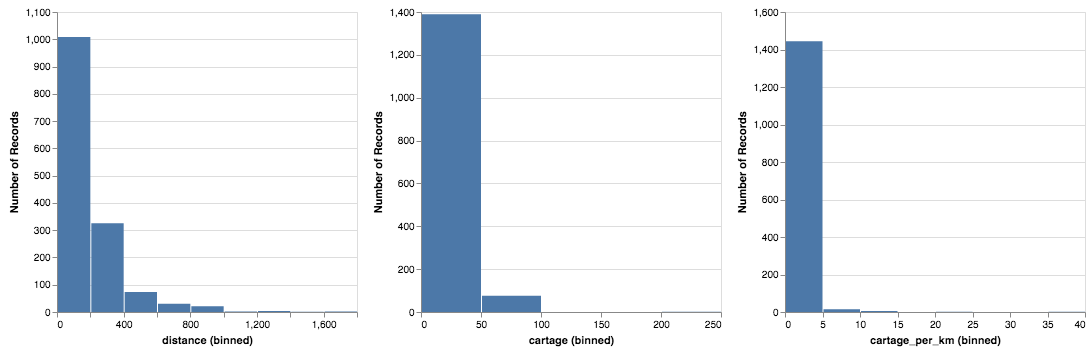

In [64]:
alt.Chart(data).mark_bar().encode(
    alt.X(alt.repeat("column"), type='quantitative', bin=True),
    y = "count()"
).properties(
    width=300,
    height=300
).repeat(
    column=['distance', 'cartage', 'cartage_per_km']
).interactive()

Both `cartage`, `distance` and `cartage_per_km` are left-skewed. We can use a log-transform to improve the distribution

In [65]:
# Log Transform the data
data["cartage_per_km_log"] = np.log10(data["cartage_per_km"])
data["distance_log"] = np.log10(data.distance)
data["cartage_log"] = np.log10(data.cartage)

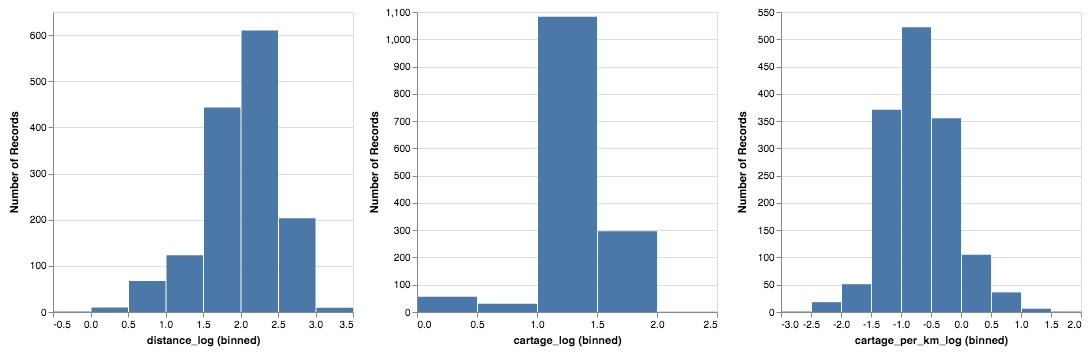

In [66]:
alt.Chart(data).mark_bar().encode(
    alt.X(alt.repeat("column"), type='quantitative', bin=True),
    y = "count()"
).properties(
    width=300,
    height=300
).repeat(
    column=['distance_log', 'cartage_log', 'cartage_per_km_log']
).interactive()

Lets see if there is any relationship between Distance and Cartage

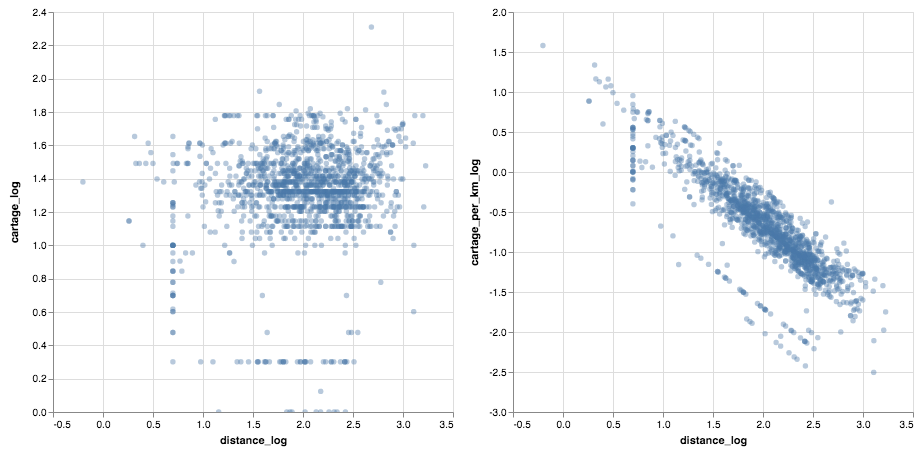

In [67]:
alt.Chart(data).mark_circle().encode(
    alt.Y(alt.repeat("column"), type='quantitative'),
    x = "distance_log",
    opacity = alt.value(0.4),
    tooltip = ["source", "dest"]
).properties(
    width=400,
    height=400
).repeat(
    column=['cartage_log', 'cartage_per_km_log']
).interactive()

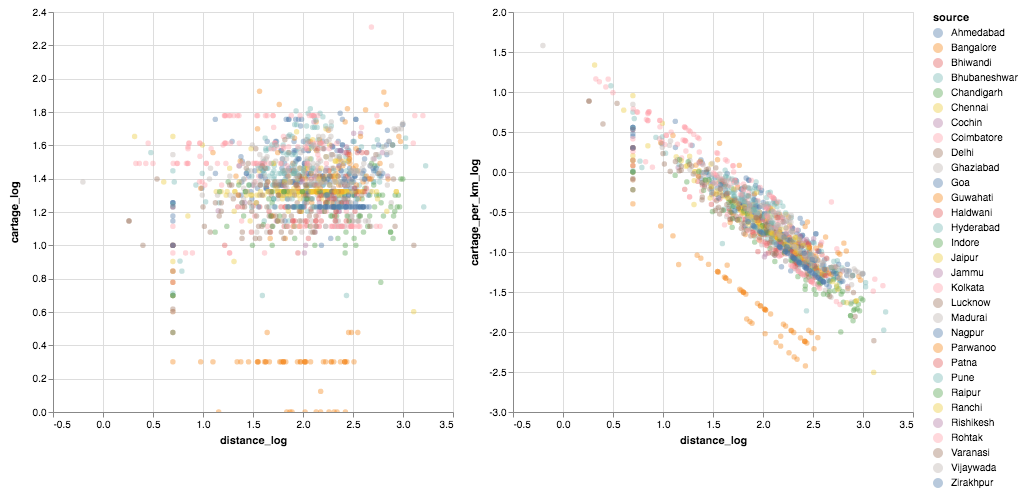

In [68]:
alt.Chart(data).mark_circle().encode(
    alt.Y(alt.repeat("column"), type='quantitative'),
    x = "distance_log",
    opacity = alt.value(0.4),
    color = "source",
    tooltip = ["source", "dest"]
).properties(
    width=400,
    height=400
).repeat(
    column=['cartage_log', 'cartage_per_km_log']
).interactive()

## Model

### 1. Simple Linear Model

$$ log(cartagePerKM) = w_{0} + w_{1}*log(distance) $$

In [69]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [70]:
X = data[["distance_log"]]
y = data[["cartage_per_km_log"]]

In [71]:
lr = Ridge()
parameter_grid = {'alpha': np.logspace(-10, 2, 12)}
lr_grid = GridSearchCV(lr, param_grid = parameter_grid, cv = 10, scoring="neg_mean_squared_error")
lr_grid.fit(X,y)
lr_grid.best_estimator_

Ridge(alpha=1e-10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [72]:
model_linear = lr_grid.best_estimator_
model_linear.fit(X,y)

Ridge(alpha=1e-10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [73]:
y_pred_linear = model_linear.predict(X)
error_linear = mean_squared_error(y_pred_linear, y)
error_linear

0.079795996308382786

In [74]:
w1 = model_linear.coef_, 
w0 = model_linear.intercept_ 
w0, w1

(array([ 1.19446117]), (array([[-0.93577762]]),))

In [75]:
def show_prediction(data, x, y, y_pred):
    baseChart = alt.Chart().properties(width=400, height=400)
    actual = baseChart.encode(x = x, y = y, opacity = alt.value(0.4))
    prediction = baseChart.encode(x = x, y = y_pred, color = alt.value("black"), size = alt.value(2))
    chart = alt.layer(actual.mark_circle(), prediction.mark_line(), data=data).interactive()
    return chart

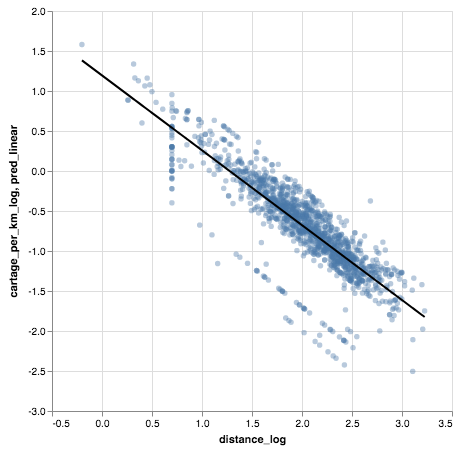

In [76]:
data["pred_linear"] = y_pred_linear
show_prediction(data, "distance_log","cartage_per_km_log", "pred_linear")

## Tree Model

In [77]:
from sklearn.tree import DecisionTreeRegressor

In [78]:
tree = DecisionTreeRegressor(min_samples_leaf=10)
parameter_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8]}
tree_grid = GridSearchCV(tree, param_grid = parameter_grid, cv = 10, scoring="neg_mean_squared_error")
tree_grid.fit(X,y)
tree_grid.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [79]:
model_tree = tree_grid.best_estimator_
model_tree.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [80]:
y_pred_tree = model_tree.predict(X)
error_tree = mean_squared_error(y_pred_tree, y)
error_tree

0.074775203889440631

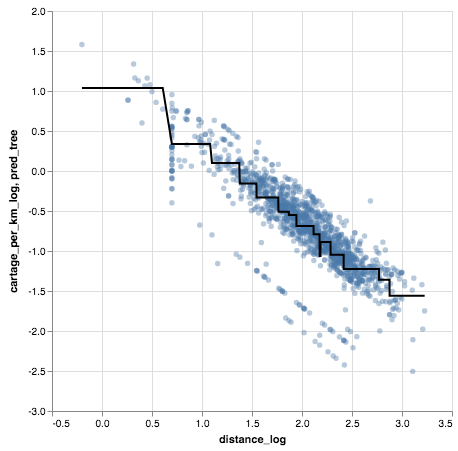

In [81]:
data["pred_tree"] = y_pred_tree
show_prediction(data, "distance_log", "cartage_per_km_log", "pred_tree")

## Ensemble Model

In [82]:
X_large = data[["sourcelat", "sourcelon", "destlat", "destlon", "distance_log"]]
y = data.cartage_per_km_log

In [83]:
from sklearn.ensemble import RandomForestRegressor

In [84]:
rf = RandomForestRegressor(min_samples_leaf=10)
parameter_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8], 'n_estimators': [10, 50, 100]}
rf_grid = GridSearchCV(rf, param_grid = parameter_grid, cv = 10, scoring="neg_mean_squared_error")
rf_grid.fit(X_large,y)
rf_grid.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [85]:
model_rf = rf_grid.best_estimator_
model_rf.fit(X_large,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [86]:
y_pred_rf = model_rf.predict(X_large)
error_rf = mean_squared_error(y_pred_rf, y)
error_rf

0.074749726386986418

In [87]:
model_rf.feature_importances_

array([  6.71912644e-04,   2.32889687e-03,   7.67269163e-04,
         5.42259468e-03,   9.90809327e-01])

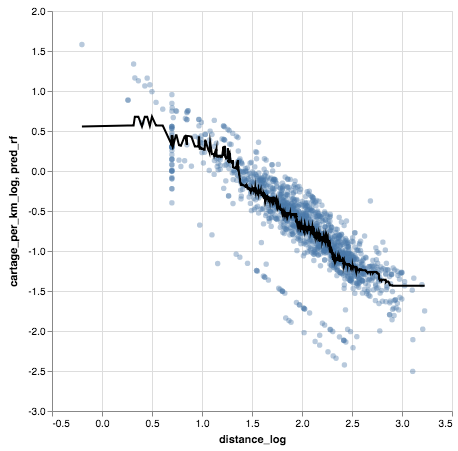

In [88]:
data["pred_rf"] = y_pred_rf
show_prediction(data, "distance_log", "cartage_per_km_log", "pred_rf")

In [89]:
data.head()

source       dest  sourcelat  sourcelon  destlat  destlon  distance  \
0  Ahmedabad  Ahmadabad      23.03       72.6    23.03    72.60      5.00   
1  Ahmedabad  Ahmedabad      23.03       72.6    23.03    72.60      5.00   
2  Ahmedabad   Ahmedabd      23.03       72.6    23.03    72.60      5.00   
3  Ahmedabad     Amreli      23.03       72.6    21.60    71.22    161.25   
4  Ahmedabad      Anand      23.03       72.6    22.55    72.95     42.40   

   cartage      qty  amount  cartage_per_km  cartage_per_km_log  distance_log  \
0     18.0     26.0     468        3.600000            0.556303      0.698970   
1     18.0  12236.0  220248        3.600000            0.556303      0.698970   
2     18.0     33.0     594        3.600000            0.556303      0.698970   
3     25.0    111.0    2775        0.155039           -0.809560      2.207500   
4     22.0    155.0    3410        0.518868           -0.284943      1.627366   

   cartage_log  pred_linear  pred_tree   pred_rf  
0     1.255273     0.540381   0.337873  0.321771  
1     1.255273     0.540381   0.337873  0.321771  
2     1.255273     0.540381   0.337873  0.321771  
3     1.397940    -0.871268  -0.886597 -0.866397  
4     1.342423    -0.328391  -0.331147 -0.338313

In [90]:
data.to_csv("model_data.csv", index=False)

That's it for now.